# Chemical Reactor Design
**Prepared by:** Zhicheng Lu (zlu3@nd.edu, 2024) and Shammah Lilonfe (slilonfe@nd.edu, 2024) at the University of Notre Dame.

## Learning Objectives

* Review syntax for Pyomo and Pyomo.DAE
* Demonstrate the power of Pyomo in solving and optimizing complex dynamic process systems

## Problem Statement: Design of Chemical Reactors for Chemical Transformations

Chemical reactors are often the most important unit operations in a chemical plant. Reactors come in many forms, however two of the most common idealizations are the continuously stirred tank reactor (CSTR) and the plug flow reactor. The CSTR is often used in modeling studies, and it can be effectively modeled as a lumped parameter system. In this example, we will consider the following reaction scheme known as the Van de Vusse reaction:

$$
\text{A} \xrightarrow{k_1} \text{B} \xrightarrow{k_2} \text{C}
$$

$$
2\text{A} \xrightarrow{k_3} \text{D}
$$

A diagram of the system is shown in figure below, where F is the volumetric flowrate. The reactor is assumed to be filled to a constant volume, and the mixture is assumed to have constant density, so the volumetric flowrate into the reactor is equal to the volumetric flowrate out of the reactor. Since the reactor is assumed to be wellmixed, the concentrations in the reactor are equivalent to the concentrations of each component flowing out of the reactor, given by $C_A$, $C_B$, $C_C$, and $C_D$.

![process scheme](../../media/contrib/reactor.png)

This example (both text and figure) was taken from Hart et al (2017).

## Install Packages and Load Modules

In [13]:
# Importing the libraries needed for the project
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()

# Importing packages to be used in this project
import pyomo.environ as pyo
import pyomo.dae as dae
import matplotlib.pyplot as plt

## Original Problem from the Reference Material

The goal is to produce product B from a feed containing reactant A. If we design a reactor that is too small, we will obtain insufficient conversion of A to the desired product B. However, given the reaction scheme, if the reactor is too large (e.g., too much reaction is allowed to occur), a significant amount of the desired product B will be further reacted to form the undesired product C. As a result, the goal in this exercise will be to solve for the optimal reactor volume producing the maximum outlet concentration for product B.

The steady-state mole balances for each of the four components are given by,

$$\begin{align*}
&0=\frac{F}{V}C_{Af}-\frac{F}{V}C_A-k_1C_A-2k_3C_A^2 \\
& 0=-\frac{F}{V}C_B+k_1C_A-k_2C_B\\
& 0=-\frac{F}{V}C_C+k_2C_B \\
& 0=-\frac{F}{V}C_D+k_3C_A^2
\end{align*}$$

The known parameters for the system are,

$$\begin{align*}
C_{Af}=10^4\,\mathrm{\frac{gmol}{m^3}}\quad{k_1=\frac{5}{6}\,\mathrm{min^{-1}}}\quad{k_2=\frac{5}{3}\,\mathrm{min^{-1}}}\quad{k_3=\frac{1}{6000}\,\mathrm{\frac{m^3}{gmol\cdot min}}}
\end{align*}$$

Since the volumetric flowrate F always appears as the numerator over the reactor volume V, it is common to consider this ratio as a single variable, called the space velocity (sv). Our optimization formulation will seek to find the space-velocity that maximizes the outlet concentration of the desired product B.

This original problem was taken from Hart et al (2017).

### Optimization Model Formulation

Mathematically, we want to solve the following optimal reactor volume problem:

$$\begin{align*}
\max_{S_v} \quad & C_B \\ 
\mathrm{s.t.} \quad & 0=S_vC_{Af}-S_vC_A-k_1C_A-2k_3C_A^2 \\
& 0=-S_vC_B+k_1C_A-k_2C_B \\
& 0=-S_vC_C+k_2C_B \\
& 0=-S_vC_D+k_3C_A^2 \\
& C_A, C_B, C_C, C_D, S_v \geq 0.
\end{align*}$$

Here "s.t." means "subject to", i.e., the constraints.

### Degrees of Freedom Analysis

From the optimization model formulated above:\
Number of variables = 5 \
Number of equality constraints = 4 \
Therefore, the degrees of freedom = 5 - 4 = 1

### Pyomo Implementation of the Original Problem

In [14]:
# function that creates pyomo model for the reaction system
def create_model(k1, k2, k3, caf):
    """Creates reactor model
    Argument:
        caf: feed concentration of A, gmol/m^3
        k1: rate constant for A to B, min^-1
        k2: rate constant for B to C, min^-1
        k3: rate constant for 2A to D, m^3/(gmol.min)

    Returns:
        model: pyomo model"""
    # Create a Pyomo model
    model = pyo.ConcreteModel()
    
    # create the variables
    model.sv = pyo.Var(initialize=1.0, within=pyo.PositiveReals) # space-velocity
    model.ca = pyo.Var(initialize=5000.0, within=pyo.PositiveReals) # concentration of A
    model.cb = pyo.Var(initialize=2000.0, within=pyo.PositiveReals) # concentration of B
    model.cc = pyo.Var(initialize=2000.0, within=pyo.PositiveReals) # concentration of C
    model.cd = pyo.Var(initialize=1000.0, within=pyo.PositiveReals) # concentration of D
    
    # create the objective
    model.obj = pyo.Objective(expr = model.cb, sense=pyo.maximize)
    
    # create the constraints
    model.ca_bal = pyo.Constraint(expr = (0 == model.sv * caf - model.sv * model.ca - k1 * model.ca - 
                                          2.0 * k3 * model.ca ** 2.0)) # species A mole balance
    model.cb_bal = pyo.Constraint(expr=(0 == -model.sv * model.cb + k1 * model.ca - k2 * model.cb)) # species B mole balance
    model.cc_bal = pyo.Constraint(expr=(0 == -model.sv * model.cc + k2 * model.cb)) # species C mole balance
    model.cd_bal = pyo.Constraint(expr=(0 == -model.sv * model.cd + k3 * model.ca ** 2.0)) # species D mole balance
    
    return model

# define data
k1 = 5.0/6.0 # min^-1
k2 = 5.0/3.0 # min^-1
k3 = 1.0/6000.0 # m^3/(gmol.min)
caf = 10000.0 # gmol/m^3

# reactor model object
m = create_model(k1, k2, k3, caf)

# solve model
solver = pyo.SolverFactory('ipopt')
solver.solve(m, tee=True)

# print the solution of sv and the outlet concentration of B
print(f"The optimum space-velocity is: {round(pyo.value(m.sv), 2)} min^-1")
print(f"The outlet concentration of species B is: {round(pyo.value(m.cb), 2)} gmol/m^3")

# calculate optimum reactor volume for a volumetric flow rate of 1 m^3/min
F = 1
optimum_reactor_volume = F / pyo.value(m.sv)
print(f"The optimum reactor volume is: {round(optimum_reactor_volume, 2)} m^3")

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

### Optimal Solution Found for the Original Problem

The optimal space-velocity is $\mathrm{1.34\,min^{-1}}$, giving an outlet concentration for B of $\mathrm{1072.44\,gmol\cdot m^{-3}}$. For a volumetric flow rate of $\mathrm{1\,m^{3}\cdot min^{-1}}$, the optimum reactor volume is $\mathrm{0.74\,m^{3}}$.

## Extension: Adding a New Species C and Considering Reaction Kinetics

In this project, species C is the desired product, and we are considering the dynamic state of the system (most often, industrial operations are dynamic). The goal of this work is to determine the volume of the reactor that will maximize the concentration of species C in the effluent after 10 minutes. Furthermore, for economic reasons, the reactor volume should not exceed $\mathrm{100\,m^3}$.

The mole balance for each of the species in this system under dynamic state is given by:

$$\begin{align*}
&\frac{dC_A}{dt}=\frac{F}{V}C_{Af}-\frac{F}{V}C_A-k_1C_A-2k_3C_A^2 \\
& \frac{dC_B}{dt}=-\frac{F}{V}C_B+k_1C_A-k_2C_B\\
& \frac{dC_C}{dt}=-\frac{F}{V}C_C+k_2C_B \\
& \frac{dC_D}{dt}=-\frac{F}{V}C_D+k_3C_A^2
\end{align*}$$

Where $C_A$, $C_B$, $C_C$ and $C_D$ are the concentrations of species A, B, C and D, respectively. $F$ is the feed flow rate, $C_{Af}$ is the concentration of species A in the feed, $k_1$, $k_2$ and $k_3$ are the rate constants of reaction 1 (species A to B), reaction 2 (species B to C) and reaction 3 (species A to D), respectively.

The data for the system are:
$$\begin{align*}
C_{Af}=10^4\,\mathrm{\frac{mol}{m^3}},\quad{k_1=\frac{5}{6}\,\mathrm{min^{-1}}},\quad{k_2=\frac{5}{3}\,\mathrm{min^{-1}}},\quad{k_3=\frac{1}{6000}\,\mathrm{\frac{m^3}{mol\cdot min}}},\quad{F=1\,\mathrm{\frac{m^3}{min}}}
\end{align*}$$

The data was obtained from Hart et al (2017).

### Optimization Model Formulation

Mathematically, we want to solve the following optimal reactor volume problem:

$$\begin{align*}
\max_{V} \quad & C_C(t=10) \\
\mathrm{s.t.} \quad & \frac{dC_A}{dt}=\frac{F}{V}C_{Af}-\frac{F}{V}C_A-k_1C_A-2k_3C_A^2 \\
& \frac{dC_B}{dt}=-\frac{F}{V}C_B+k_1C_A-k_2C_B \\
& \frac{dC_C}{dt}=-\frac{F}{V}C_C+k_2C_B \\
& \frac{dC_D}{dt}=-\frac{F}{V}C_D+k_3C_A^2 \\
& V \leq 100 \\
& C_A(t=0) = 10000, ~~ C_B(t=0) = 0 \\
& C_C(t=0) = 0, ~~ C_D(t=0) = 0 \\
\end{align*}$$

### Degrees of Freedom Analysis

From the optimization model formulated above:\
Number of variables = 5 \
Number of equality constraints = 4 \
Therefore, the degrees of freedom = 5 - 4 = 1

### Pyomo Implementation
We can use `Pyomo.dae` to automatically formulate the collocation equations (i.e., add constraints that numerically integrate the ODE model).

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

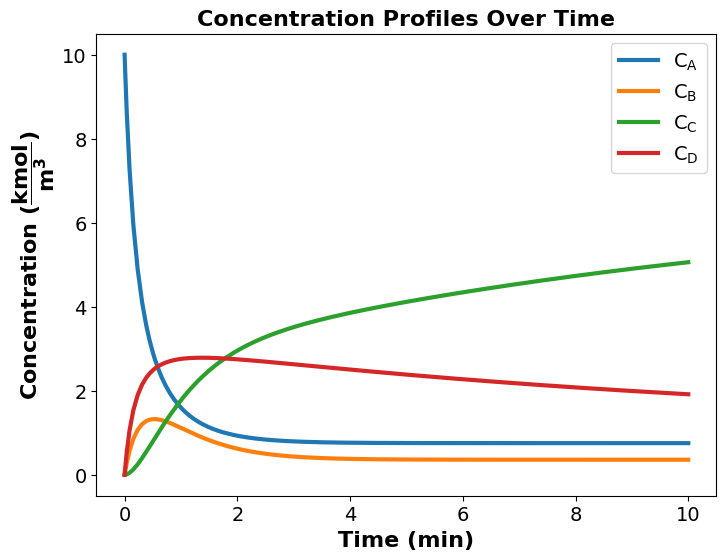

In [15]:
# function that creates pyomo model for the dynamic reaction system
def create_dynamic_model(F, CAF, k1, k2, k3):
    """Creates reactor model
    Argument:
        F: feed volumetric flow rate in m^3/min
        CAF: feed concentration of A, gmol/m^3
        k1: rate constant for A to B, min^-1
        k2: rate constant for B to C, min^-1
        k3: rate constant for 2A to D, m^3/(gmol.min)

    Returns:
        model: pyomo model"""

    # Create a Pyomo model
    model = pyo.ConcreteModel()

    # Define time as a continuous set
    model.t = dae.ContinuousSet(bounds=(0, 10))  # time from 0 to 10 minutes

    # Define variables for concentrations and reactor volume
    model.CA = pyo.Var(model.t, within=pyo.NonNegativeReals) # concentration of A
    model.CB = pyo.Var(model.t, within=pyo.NonNegativeReals) # concentration of B
    model.CC = pyo.Var(model.t, within=pyo.NonNegativeReals) # concentration of C
    model.CD = pyo.Var(model.t, within=pyo.NonNegativeReals) # concentration of D
    model.V = pyo.Var(within=pyo.NonNegativeReals, bounds=(0, 100), initialize=0) # reactor volume

    # Define derivatives of concentrations
    model.dCA_dt = dae.DerivativeVar(model.CA, wrt=model.t)
    model.dCB_dt = dae.DerivativeVar(model.CB, wrt=model.t)
    model.dCC_dt = dae.DerivativeVar(model.CC, wrt=model.t)
    model.dCD_dt = dae.DerivativeVar(model.CD, wrt=model.t)

    # CA differential equation
    def ca_rate_ode(m, t):
        return m.dCA_dt[t] == (F/m.V)*CAF - (F/m.V)*m.CA[t] - k1*m.CA[t] - 2*k3*m.CA[t]**2
    model.CA_ode = pyo.Constraint(model.t, rule=ca_rate_ode)

    # CB differential equation
    def cb_rate_ode(m, t):
        return m.dCB_dt[t] == -(F/m.V)*m.CB[t] + k1*m.CA[t] - k2*m.CB[t]
    model.CB_ode = pyo.Constraint(model.t, rule=cb_rate_ode)

    # CC differential equation
    def cc_rate_ode(m, t):
        return m.dCC_dt[t] == -(F/m.V)*m.CC[t] + k2*m.CB[t]
    model.CC_ode = pyo.Constraint(model.t, rule=cc_rate_ode)

    # CD differential equation
    def cd_rate_ode(m, t):
        return m.dCD_dt[t] == -(F/m.V)*m.CD[t] + k3*m.CA[t]**2
    model.CD_ode = pyo.Constraint(model.t, rule=cd_rate_ode)

    # Initial conditions
    def init_conditions(m):
        yield m.CA[0] == CAF
        yield m.CB[0] == 0
        yield m.CC[0] == 0
        yield m.CD[0] == 0
    model.init_conditions = pyo.ConstraintList(rule=init_conditions)

    # Objective: Maximize concentration of C at t = 10 minutes
    def objective_function(m):
        return m.CC[10]
    model.objective = pyo.Objective(rule=objective_function, sense=pyo.maximize)

    return model

# Parameters from data
conc_A_feed = 10000  # gmol/m^3
k1 = 5/6  # min^-1
k2 = 5/3  # min^-1
k3 = 1/6000  # m^3/gmol/min
feed_flowrate = 1 # m^3/min

# reactor model object
reactor_model = create_dynamic_model(feed_flowrate, conc_A_feed, k1, k2, k3)

# Discretize the model using collocation
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(reactor_model, nfe=20, ncp=10)

# Solve the model
solver = pyo.SolverFactory('ipopt')
results = solver.solve(reactor_model, tee=True)

# print optimal reactor volume
optimal_reactor_volume = pyo.value(reactor_model.V) # m^3
print(f"Optimal reactor volume is: {round(optimal_reactor_volume, 2)} m^3")

# Extract the concentration of C at t = 10 minutes
optimal_concentration_C = pyo.value(reactor_model.CC[10])*10**(-3) # kmol/m^3
print(f"Maximum Concentration of C at optimal reactor volume is: {round(optimal_concentration_C, 2)} kmol/m^3")


# Extract results for plotting
time = [t for t in reactor_model.t] # minutes
CA_values = [(pyo.value(reactor_model.CA[t])*10**(-3)) for t in reactor_model.t] # kmol/m^3
CB_values = [(pyo.value(reactor_model.CB[t])*10**(-3)) for t in reactor_model.t] # kmol/m^3
CC_values = [(pyo.value(reactor_model.CC[t])*10**(-3)) for t in reactor_model.t] # kmol/m^3
CD_values = [(pyo.value(reactor_model.CD[t])*10**(-3)) for t in reactor_model.t] # kmol/m^3

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(time, CA_values, label='$\mathrm{C_{A}}$')
plt.plot(time, CB_values, label='$\mathrm{C_{B}}$')
plt.plot(time, CC_values, label='$\mathrm{C_{C}}$')
plt.plot(time, CD_values, label='$\mathrm{C_{D}}$')
plt.xlabel('Time (min)', fontsize=16,fontweight='bold')
plt.ylabel('Concentration ($\mathbf{\dfrac{kmol}{m^3}}$)', fontsize=16,fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Concentration Profiles Over Time', fontsize=16,fontweight='bold')
plt.legend()
plt.show()

### Pyomo Enables Dynamic Chemical Reactor Design

From the concentration profile above, $C_{A}$ decreases with time. This makes sense beacause species A is the reactant and it is continuously been consumed to form the products. 

Also, it is observed that $C_{B}$ and $C_{D}$ increase at the early phase of the reaction, but then start to decrease at a later time. This is because at the early phase of the reaction, only species B and D are produced until a later time when species C begins to form, and since the rate constant of species C ($k_2$) is faster than the rate constants of species B and D ($k_1$ and $k_3$ respectively), $C_{C}$ continue to increase whereas $C_{B}$ and $C_{D}$ deplete.

The optimization result shows that the optimal reactor volume required to maximize the desired product (species C)  is $\mathrm{11.35\,m^{3}}$ and the corresponding species C concentration is $\mathrm{5.06\,kmol\cdot m^{-3}}$.


## Take Away Messages

* Pyomo is a powerful tool in solving complex dynamic optimization problems
* Proper modelling of the problem is key to obtaining quality results

## Reference
Hart, W. E., Laird, C. D., Watson, J. P., Woodruff, D. L., Hackebeil, G. A., Nicholson, B. L., & Siirola, J. D. (2017). Pyomo-optimization modeling in python (Vol. 67, p. 277). Berlin: Springer.

